In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageOps
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

In [ ]:
# you can switch the commented lines here to pick the other model

# inception resnet version 2
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# You can choose ssd mobilenet version 2 instead and compare the results
#module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

In [ ]:
model = hub.load(module_handle)

In [ ]:
# take a look at the available signatures for this particular model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7F57DC6C5E80>}))

In [ ]:
detector = model.signatures['default']

In [ ]:
def download_and_resize_image(url, new_width=256, new_height=256):
    '''
    Fetches an image online, resizes it and saves it locally.
    
    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    
    
    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # opens the given URL
    response = urlopen(url)
    
    # reads the image fetched from the URL
    image_data = response.read()
    
    # puts the image data in memory buffer
    image_data = BytesIO(image_data)
    
    # opens the image
    pil_image = Image.open(image_data)
    
    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")
    
    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image downloaded to %s." % filename)
    
    return filename

In [ ]:
# You can choose a different URL that points to an image of your choice
image_url = "https://upload.wikimedia.org/wikipedia/commons/f/fb/20130807_dublin014.JPG"

# download the image and use the original height and width
downloaded_image_path = download_and_resize_image(image_url, 3872, 2592)

Image downloaded to /tmp/tmpz4gfh_6y.jpg.


In [ ]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path (string) -- path to a locally saved JPEG image
    
    Returns:
        (tensor) -- an image tensor
    '''
    
    # read the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


def run_detector(detector, path):
    '''
    Runs inference on a local file using an object detection model.
    
    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
    '''
    
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    result = detector(converted_img)

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))

    print(result["detection_scores"])
    print(result["detection_class_labels"])
    print(result["detection_boxes"])
    print(result["detection_class_entities"])

    return result["detection_scores"], result["detection_class_labels"], result["detection_boxes"], result["detection_class_entities"]

In [ ]:
# runs the object detection model and prints information about the objects found
sc, cs, bx, names = run_detector(detector, downloaded_image_path)

Found 100 objects.
[0.65321755 0.6105044  0.6015257  0.5925565  0.59177715 0.58154935
 0.5505316  0.49575576 0.47424877 0.47322184 0.44066516 0.40511423
 0.39803788 0.39406568 0.3714853  0.3615593  0.3615071  0.34689158
 0.33362216 0.31252843 0.2887797  0.25758243 0.2574886  0.2519606
 0.24782136 0.23412377 0.20431975 0.20324676 0.17988248 0.17964779
 0.17374572 0.16431473 0.1603114  0.15895231 0.15620404 0.1546884
 0.1475448  0.13622677 0.12740056 0.12555611 0.1210271  0.11813046
 0.11387327 0.11229134 0.11129139 0.09718708 0.09137256 0.08976037
 0.08880259 0.08633586 0.08337478 0.0809518  0.07988787 0.07741443
 0.0773216  0.07631017 0.07507854 0.0738608  0.0723334  0.07204108
 0.07110199 0.06935615 0.068256   0.06427874 0.06248545 0.06226397
 0.06211134 0.05940052 0.05798776 0.05784459 0.05725625 0.05346687
 0.05304344 0.05242874 0.04892622 0.04813048 0.04578416 0.04424165
 0.04337565 0.04277812 0.04262631 0.04163568 0.04081763 0.03975999
 0.03945964 0.03944279 0.0386399  0.0376906  

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3690, done.
remote: Counting objects: 100% (3690/3690), done.
remote: Compressing objects: 100% (3076/3076), done.
remote: Total 3690 (delta 990), reused 1520 (delta 563), pack-reused 0
Receiving objects: 100% (3690/3690), 48.75 MiB | 25.72 MiB/s, done.
Resolving deltas: 100% (990/990), done.
Updating files: 100% (3352/3352), done.


In [ ]:
!apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
%%bash

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached avro_python3-1.10.2-py3-none-any.whl
  Using cached apache_beam-2.45.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.6 MB)
  Using cached lvis-0.5.3-py3-none-any.whl (14 kB)
  Using cached tf_models_official-2.11.3-py2.py3-none-any.whl (2.3 MB)
  Using cached tensorflow_io-0.31.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (26.9 MB)
  Using cached sacrebleu-2.2.0-py3-none-any.whl (116 kB)
  Using cached portalocker-2.7.0-py2.py3-none-any.whl (15 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached immutabledict-2.2.3-py3-none-any.whl (4.0 kB)
  Using cached tensorflow_text-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.8 MB)
  Using cached seqeval-1.2.2-py3-none-any.

In [ ]:
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
import numpy as  np

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/oid_v4_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'Tortoise'},
 2: {'id': 2, 'name': 'Container'},
 3: {'id': 3, 'name': 'Magpie'},
 4: {'id': 4, 'name': 'Sea turtle'},
 5: {'id': 5, 'name': 'Football'},
 6: {'id': 6, 'name': 'Ambulance'},
 7: {'id': 7, 'name': 'Ladder'},
 8: {'id': 8, 'name': 'Toothbrush'},
 9: {'id': 9, 'name': 'Syringe'},
 10: {'id': 10, 'name': 'Sink'},
 11: {'id': 11, 'name': 'Toy'},
 12: {'id': 12, 'name': 'Organ'},
 13: {'id': 13, 'name': 'Cassette deck'},
 14: {'id': 14, 'name': 'Apple'},
 15: {'id': 15, 'name': 'Human eye'},
 16: {'id': 16, 'name': 'Cosmetics'},
 17: {'id': 17, 'name': 'Paddle'},
 18: {'id': 18, 'name': 'Snowman'},
 19: {'id': 19, 'name': 'Beer'},
 20: {'id': 20, 'name': 'Chopsticks'},
 21: {'id': 21, 'name': 'Human beard'},
 22: {'id': 22, 'name': 'Bird'},
 23: {'id': 23, 'name': 'Parking meter'},
 24: {'id': 24, 'name': 'Traffic light'},
 25: {'id': 25, 'name': 'Croissant'},
 26: {'id': 26, 'name': 'Cucumber'},
 27: {'id': 27, 'name': 'Radish'},
 28: {'id': 28, 'name':

In [ ]:
im = viz_utils.visualize_boxes_and_labels_on_image_array(
    image=np.array(Image.open('/tmp/tmpz4gfh_6y.jpg')),
    boxes=bx,
    classes=cs,
    scores=sc,
    category_index=category_index,
    use_normalized_coordinates=True,
    min_score_thresh=.40
)

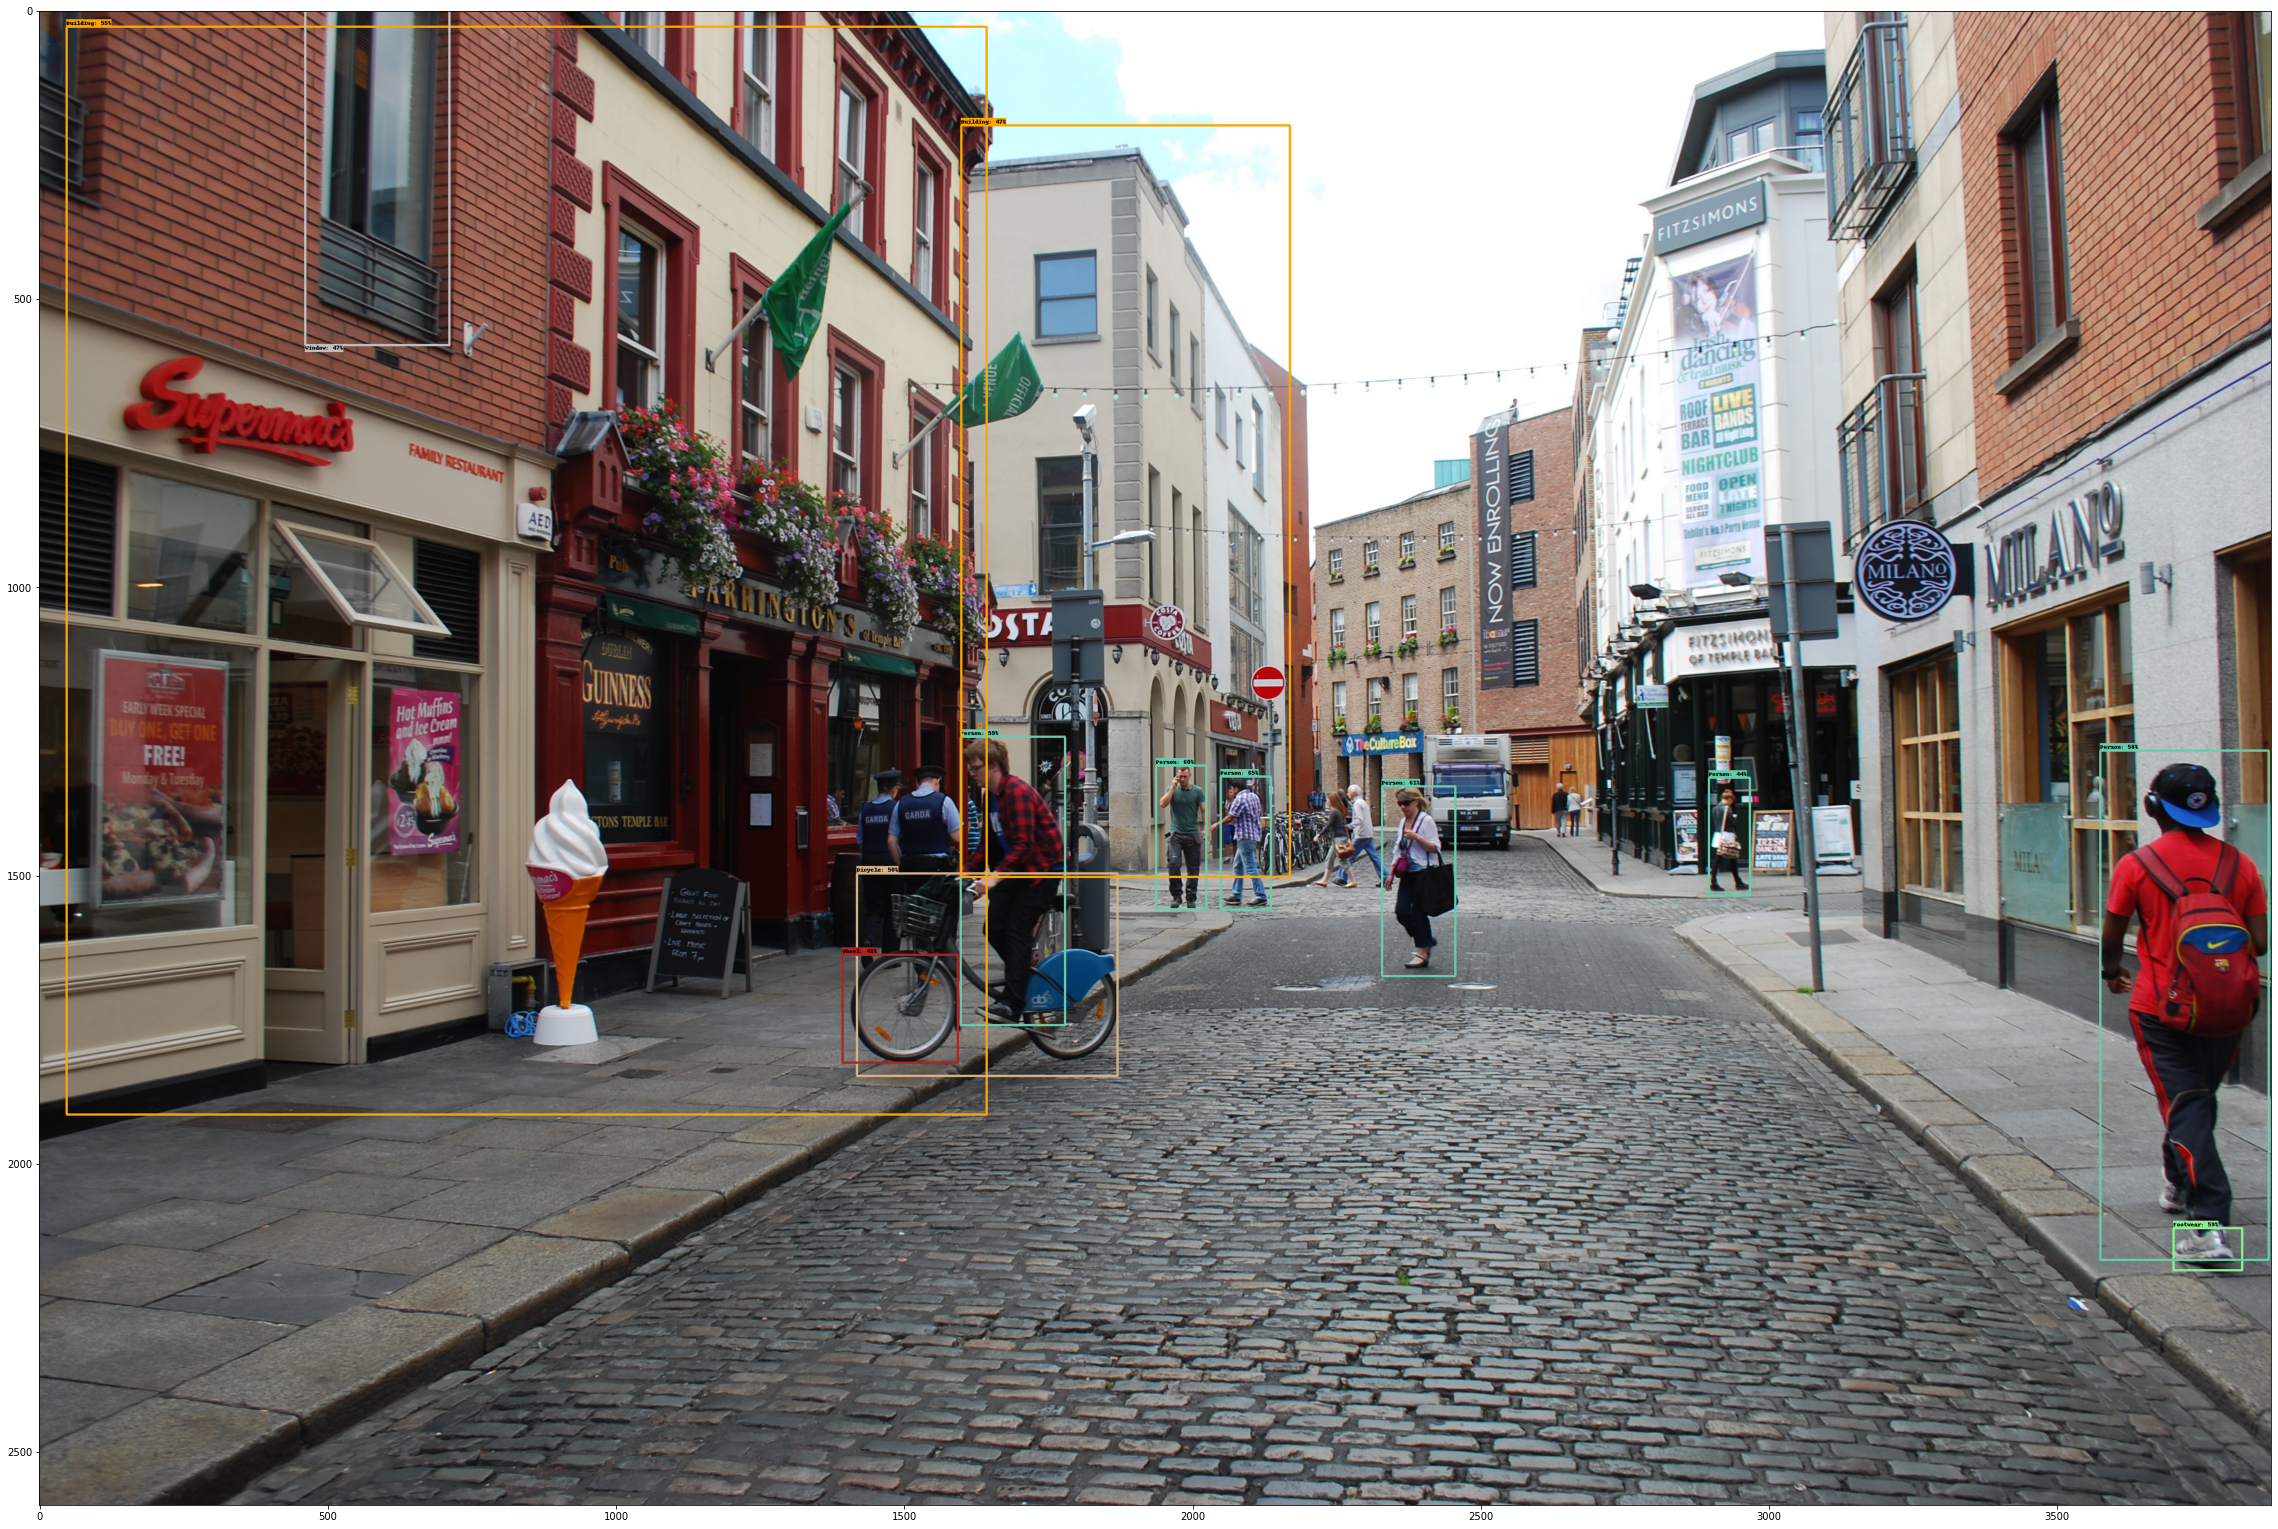

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(40,64))
plt.imshow(im)